In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.spatial.distance import cdist
import itertools
from matplotlib import colormaps
from matplotlib.patches import Arc,Rectangle
from synthetic_signal import SignalGenerator

In [2]:
WLEN = 120
M_WLEN =100
N_SIGNALS = 10

In [3]:
np.random.seed(0)
sg = SignalGenerator(1,M_WLEN,1,4,"Sin",sparsity=10,min_rep=2,max_rep=2,walk_amplitude=0.2)
sg.generate()
signal = sg.signal_
sg.plot()

In [4]:
from neighborhood import KNN

In [5]:
knn = KNN(1,WLEN,"LTNormalizedEuclidean")

In [6]:
knn.fit(signal)

In [7]:
def amp_matrixprofile(signal,wlen): 
    X =sliding_window_view(signal,wlen)
    X = X/ np.linalg.norm(X,axis=1).reshape(-1,1)
    A = cdist(X,X)
    for i in range(wlen): 
        np.fill_diagonal(A[i:,:],np.inf)
        np.fill_diagonal(A[:,i:],np.inf)
    P = np.min(A,axis=1)
    IDX = np.argmin(A,axis = 1)
    return P,IDX

In [8]:
def z_matrixprofile(signal,wlen): 
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    X = X-X_bar
    X = X/np.linalg.norm(X,axis=1).reshape(-1,1)
    A = cdist(X,X)
    for i in range(wlen): 
        np.fill_diagonal(A[i:,:],np.inf)
        np.fill_diagonal(A[:,i:],np.inf)
    P = np.min(A,axis=1)
    IDX = np.argmin(A,axis = 1)
    return P,IDX

In [9]:
def z_distanceprofile(signal,subsequence): 
    wlen = subsequence.shape[0]
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    X = X-X_bar
    X = X/np.linalg.norm(X,axis=1).reshape(-1,1)
    sub = subsequence.copy()
    sub = sub-np.mean(sub)
    sub = sub/np.linalg.norm(sub)
    sub = sub.reshape(1,-1)
    distance_profile = np.linalg.norm(X-sub,axis=1)
    return distance_profile


In [10]:
def a_matrixprofile(signal,wlen):
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    t = np.arange(wlen)
    t_bar = np.mean(t)
    a = (np.sum(X*t,axis=1).reshape(-1,1)/wlen - X_bar*t_bar)/np.std(t)**2
    b = X_bar - a*t_bar
    X = X- (a*t +b)
    X /= np.linalg.norm(X,axis=1).reshape(-1,1)
    A = cdist(X,X)
    for i in range(wlen):
        np.fill_diagonal(A[i:,:],np.inf)
        np.fill_diagonal(A[:,i:],np.inf)
    P = np.min(A,axis=1)
    IDX = np.argmin(A,axis = 1)
    return P,IDX

In [11]:
def a_distanceprofile(signal,subsequence): 
    wlen = subsequence.shape[0]
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    t = np.arange(wlen)
    t_bar = np.mean(t)
    a = (np.sum(X*t.reshape(1,-1),axis=1).reshape(-1,1)/wlen - X_bar*t_bar)/np.std(t)**2
    b = X_bar - a*t_bar
    X = X- (a*t +b)
    X /= np.linalg.norm(X,axis=1).reshape(-1,1)
    sub = subsequence.copy()
    a_sub = (np.sum(sub*t)/wlen -t_bar*np.mean(sub))/np.std(t)**2
    b_sub = np.mean(sub) - a_sub * t_bar
    sub = sub - (a_sub * t + b_sub)
    sub = sub/np.linalg.norm(sub)
    sub = sub.reshape(1,-1)
    distance_profile = np.linalg.norm(X-sub,axis=1)
    return distance_profile


In [12]:
T = np.arange(WLEN)
X =sliding_window_view(signal,WLEN)
np.sum(X*T.reshape(1,-1),axis=1).reshape(-1,1)/WLEN


array([[-32.15494195],
       [-27.66236081],
       [-23.34191432],
       ...,
       [158.64305782],
       [159.80999555],
       [160.83983593]])

In [13]:
np.mean(T)

59.5

In [14]:
np.convolve(T[::-1],signal,"valid")/WLEN

array([-32.15494195, -27.66236081, -23.34191432, ..., 158.64305782,
       159.80999555, 160.83983593])

In [15]:
Pz,IDXz= z_matrixprofile(signal,WLEN)
Pa,IDXa = a_matrixprofile(signal,WLEN)
Pamp,IDXamp = amp_matrixprofile(signal,WLEN)

[[-0.70452245]
 [-0.67027292]
 [-0.63460653]
 ...
 [ 2.3396385 ]
 [ 2.35442302]
 [ 2.36953184]]
[[0.00813735]
 [0.01018311]
 [0.01201515]
 ...
 [0.0161966 ]
 [0.016436  ]
 [0.01654506]]


In [18]:
knn.distance_.alphas_

array([0.00813735, 0.01018311, 0.01201515, ..., 0.0161966 , 0.016436  ,
       0.01654506])

In [19]:
knn.dists_

array([[0.53184536],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

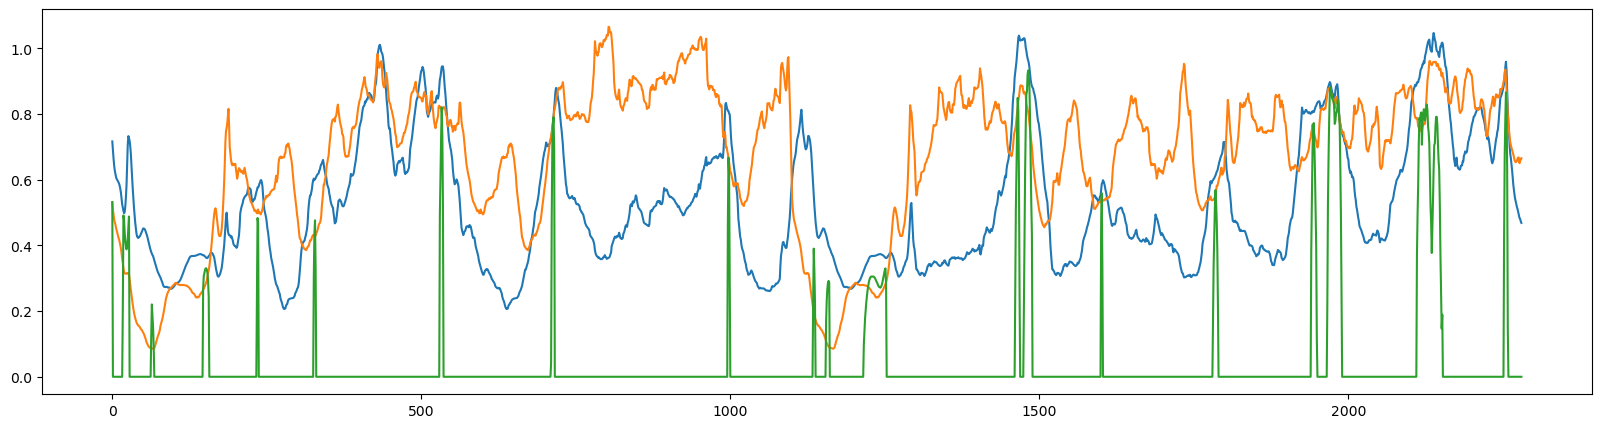

In [20]:
plt.figure(figsize=(20,5))
plt.plot(Pz)
plt.plot(Pa)
plt.plot(knn.dists_.reshape(-1))

In [1266]:
def plot_signal_profil(signal,wlen,Pa,IDXa,Pz,IDXz,TrueIDX=None):
    idxa = np.argmin(Pa)
    idxz = np.argmin(Pz)
    fig,axs = plt.subplots(3,1,sharex=True,figsize = (20,9))

    if TrueIDX is not None: 
        for pos in TrueIDX:
            for i in range(3): 
                axs[i].axvspan(pos,pos+wlen,facecolor = "blue", alpha=0.1,label = "True position")

    axs[0].plot(signal, color = "black", alpha = 0.2)
    time = np.arange(idxa,idxa+wlen)
    axs[0].plot(time,signal[time],color = "green",label= "LT-Motif")
    idxa_bis = IDXa[idxa]
    time = np.arange(idxa_bis,idxa_bis+wlen)
    axs[0].plot(time,signal[time],color = "green")

    time = np.arange(idxz,idxz+wlen)
    axs[0].plot(time,signal[time],color = "red", label = "AO-Motif")
    idxz_bis = IDXz[idxz]
    time = np.arange(idxz_bis,idxz_bis+wlen)
    axs[0].plot(time,signal[time],color = "red")

    axs[1].plot(Pa, color = "black", alpha = 0.2)
    axs[1].scatter([idxa,idxa_bis],[Pa[idxa],Pa[idxa_bis]],100,color = "green", marker = "X",label = "LT-Start")

    axs[2].plot(Pz, color = "black",alpha = 0.2)
    axs[2].scatter([idxz,idxz_bis],[Pz[idxz],Pz[idxz_bis]],100,color = "red", marker = "X", label = "AO-Start")


    axs[0].set_title("Signal")
    axs[1].set_title("Linear trend invariant profile")
    axs[2].set_title("Amplitude offset invariant profile")

    handles, labels = axs[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[0].legend(by_label.values(), by_label.keys())

    handles, labels = axs[1].get_legend_handles_labels()
    axs[1].legend([handles[-1]],[labels[-1]])
    
    handles, labels = axs[2].get_legend_handles_labels()
    axs[2].legend([handles[-1]],[labels[-1]])

    fig.tight_layout()
    return fig,axs

(<Figure size 2000x900 with 3 Axes>,
 array([<Axes: title={'center': 'Signal'}>,
        <Axes: title={'center': 'Linear trend invariant profile'}>,
        <Axes: title={'center': 'Amplitude offset invariant profile'}>],
       dtype=object))

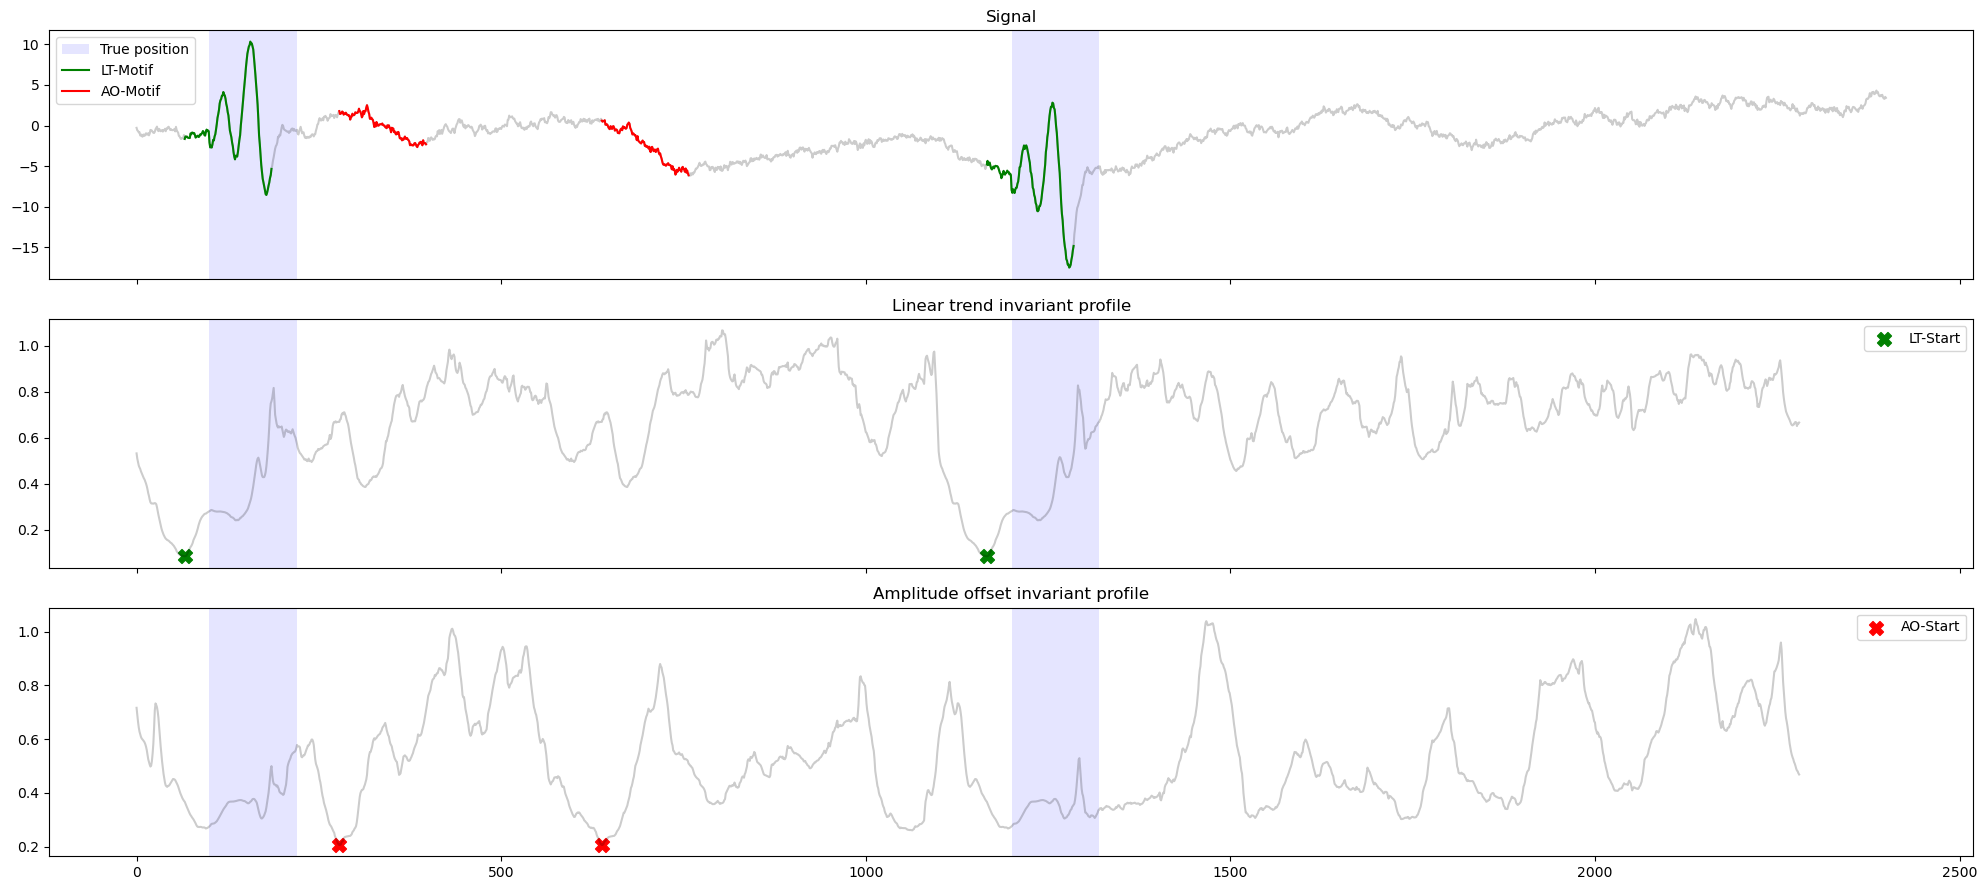

In [1267]:
plot_signal_profil(signal,WLEN,Pa,IDXa,Pz,IDXz,list(zip(*sg.positions_[0]))[0])

In [1268]:
from metric import SingleEventScore
ses = SingleEventScore()

In [1269]:
dataset = []
labels = []
for i in range(N_SIGNALS): 
    np.random.seed(i)
    signal, label = sg.generate()
    dataset.append(signal)
    labels.append(label)

In [1270]:
def prediction_mask(L,wlen,P,IDX): 
    idx1 = np.argmin(P)
    idx2 = IDX[idx1]
    mask = np.zeros(L)
    mask[idx1:idx1+wlen] = 1
    mask[idx2:idx2+wlen] = 1
    return mask

In [1271]:
final_score = []
for method in [a_matrixprofile,z_matrixprofile]:
    t_scores = []
    for signal,label in zip(dataset,labels): 
        P,IDX = method(signal,WLEN)
        L = signal.shape[0]
        mask = prediction_mask(L,WLEN,P,IDX)
        t_scores.append(ses.all_score(label.reshape(-1),mask))
    avg_score = []
    for lst in list(zip(*t_scores)):
        avg_score.append(np.mean(lst,axis=0))
    final_score.append(avg_score)

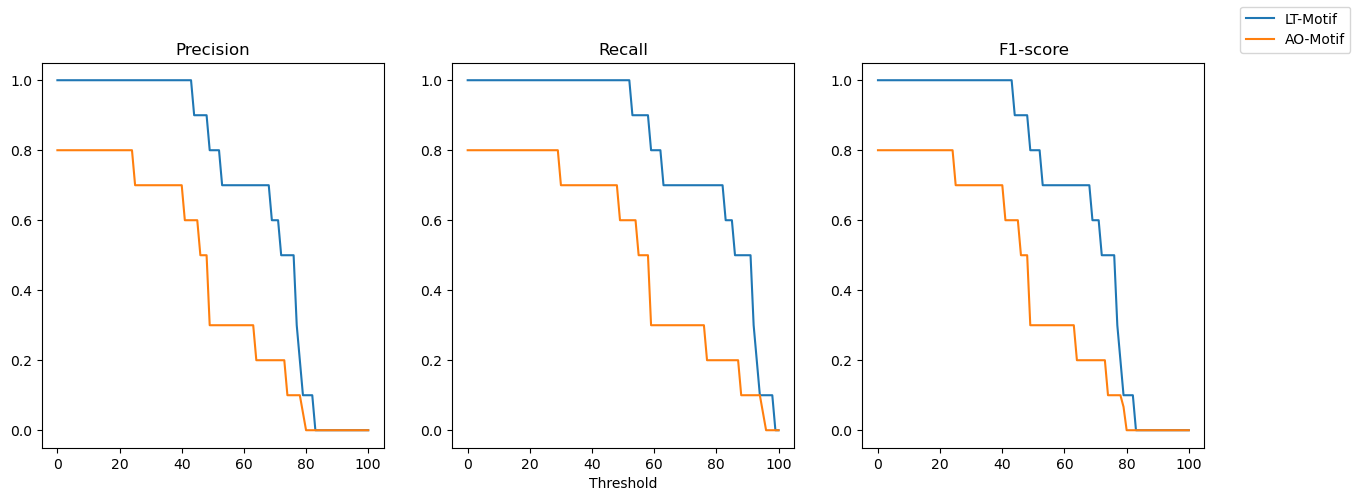

In [1272]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
labels = ["LT-Motif", "AO-Motif"]
for i in range(2): 
    for j in range(3):
        axs[j].plot(final_score[i][j], label = labels[i])
axs[0].set_title("Precision")
axs[1].set_title("Recall")
axs[1].set_xlabel("Threshold")
axs[2].set_title("F1-score")

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys())

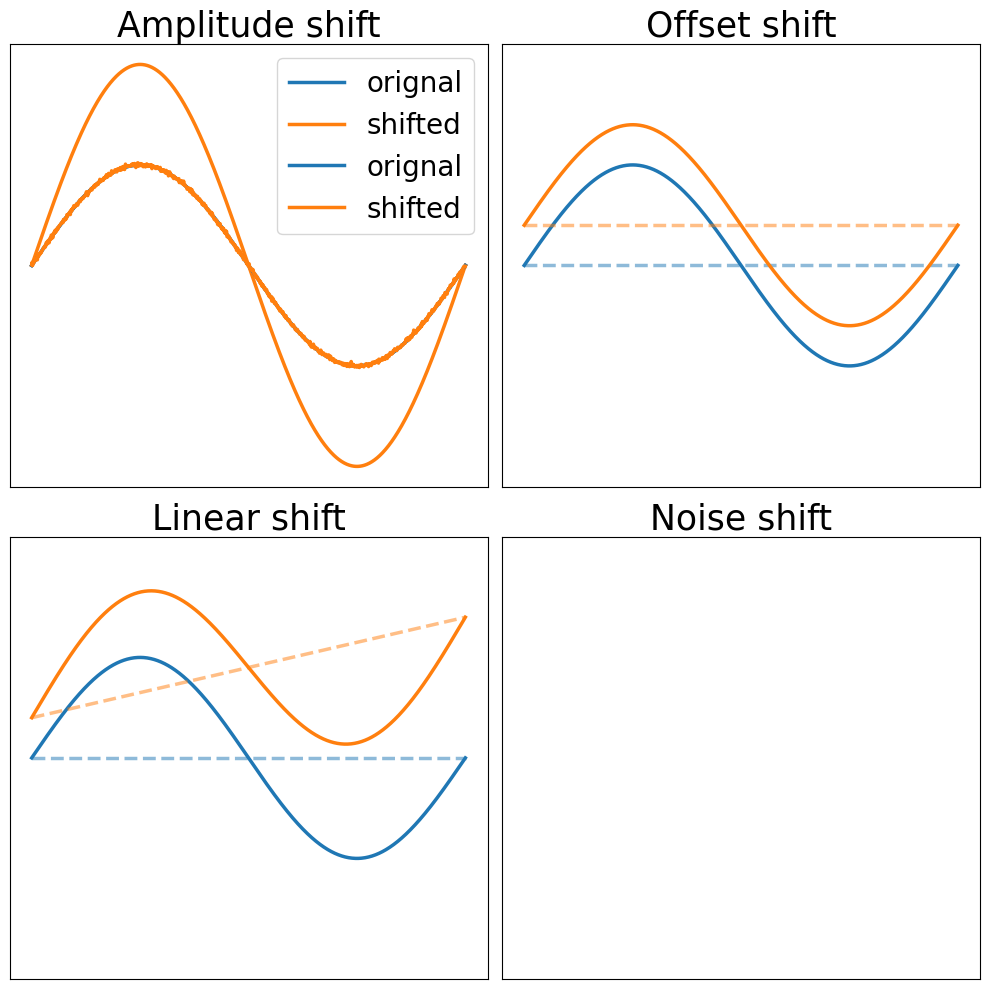

In [1339]:
fig,axs = plt.subplots(2,2,figsize = (10,10),sharex=True, sharey=True)
t = np.linspace(0,2*np.pi,1000)
s = np.sin(t)

axs[0,0].plot(s,color = "tab:blue",label="orignal",linewidth=2.5)
axs[0,0].plot(2*s,color = "tab:orange",label = "shifted",linewidth=2.5)

offset = 0.4
axs[0,1].hlines(0,0,1000,color="tab:blue",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[0,1].plot(s,color = "tab:blue",linewidth=2.5)
axs[0,1].hlines(offset,0,1000,color="tab:orange",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[0,1].plot(s +offset,color = "tab:orange",linewidth=2.5)

lt = 1*np.linspace(0,1,1000) + 0.4
axs[1,0].hlines(0,0,1000,color="tab:blue",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[1,0].plot(s,color = "tab:blue",linewidth=2.5)
axs[1,0].plot(lt,color="tab:orange",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[1,0].plot(s+lt,color = "tab:orange",linewidth=2.5)

axs[0,0].plot(s,color = "tab:blue",label="orignal",linewidth=2.5)
axs[0,0].plot(s+np.random.randn(1000)*0.01,color = "tab:orange",label = "shifted",linewidth=2.5)

axs[0,0].set_title("Amplitude shift",fontsize=25)
axs[0,1].set_title("Offset shift",fontsize=25)
axs[1,0].set_title("Linear shift",fontsize=25)
axs[1,1].set_title("Noise shift",fontsize=25)




axs[0,0].legend(fontsize=20)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

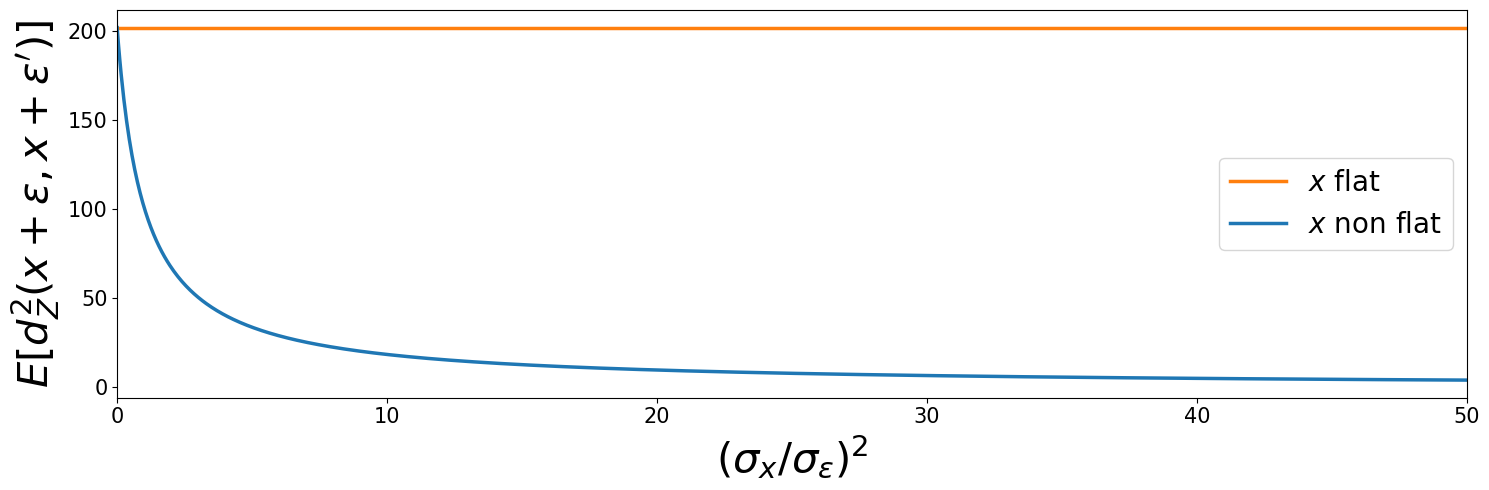

In [1296]:
wlen = 100 
ratio_var = np.linspace(0,50,1000)
mean_dist = 2*wlen *(wlen/(wlen-1))*1/(1+ratio_var)

plt.figure(figsize = (15,5))
plt.axhline(2* wlen*(wlen/(wlen-1)),color = "tab:orange", label=r"$x$ flat",linewidth=2.5)
plt.plot(ratio_var,mean_dist, label=r"$x$ non flat",color="tab:blue",linewidth=2.5)
plt.xlim((0,50))
plt.xlabel(r"$(\sigma_x/\sigma_\epsilon)^2$",fontsize = 30)
plt.ylabel(r"$E[d^2_Z(x+\epsilon,x+\epsilon')]$",fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks(np.array([0,0.5,1,1.5,2])*wlen,fontsize=15)
plt.legend(fontsize=20)
plt.tight_layout()

/var/folders/15/735bgx_91fgg0fvp4rvhj_6m0000gn/T/ipykernel_33521/54613124.py:12: MatplotlibDeprecationWarning:

Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.

/var/folders/15/735bgx_91fgg0fvp4rvhj_6m0000gn/T/ipykernel_33521/54613124.py:32: MatplotlibDeprecationWarning:

The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.

/var/folders/15/735bgx_91fgg0fvp4rvhj_6m0000gn/T/ipykernel_33521/54613124.py:34: MatplotlibDeprecationWarning:

The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.



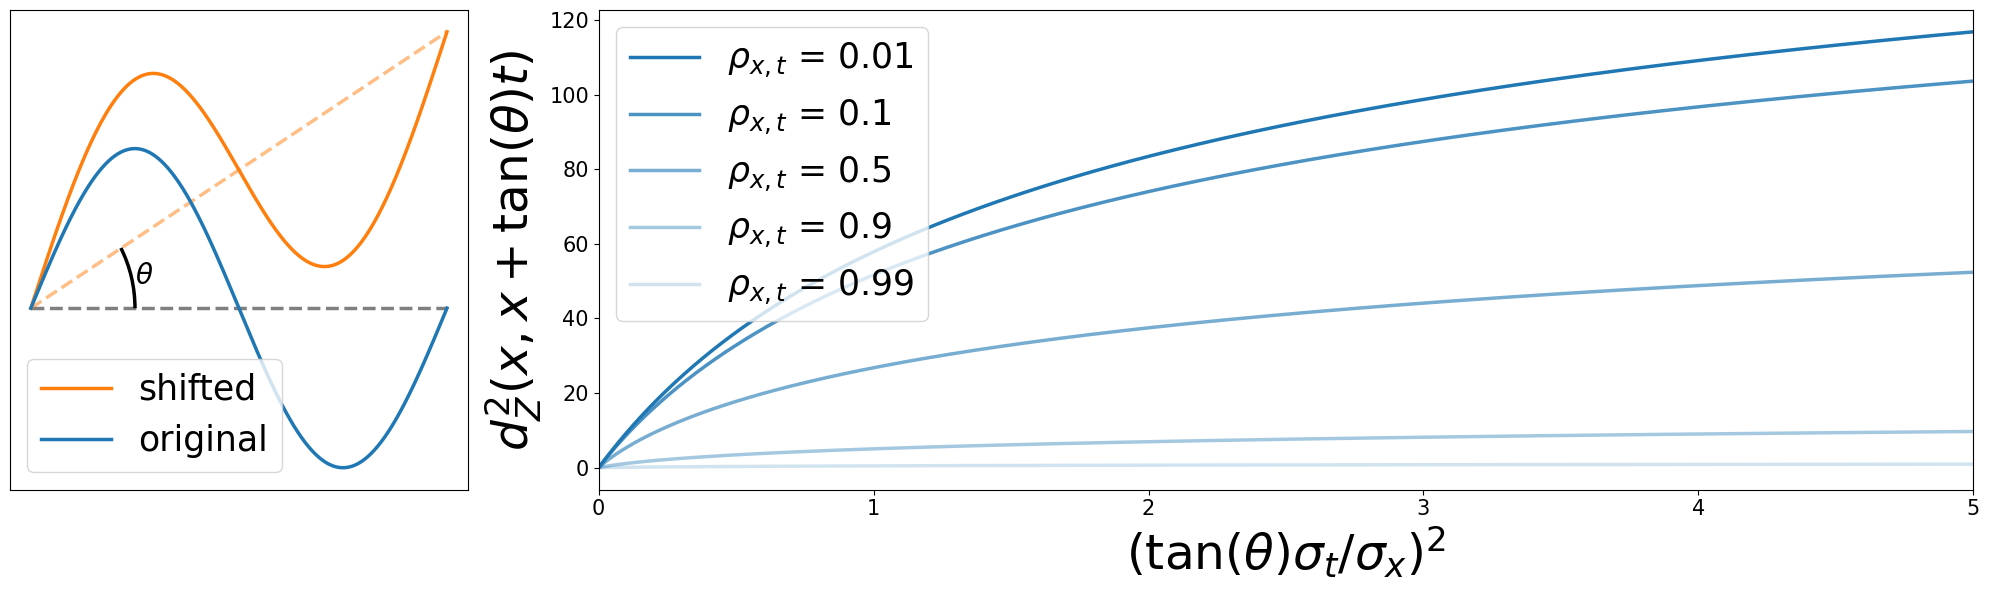

In [1310]:
fig,axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [1,3]},figsize = (20,6))

t = np.linspace(0,1,1000)
s = np.sin(2*np.pi*t)
thz = np.pi/3
line = np.tan(thz)*t

axs[0].hlines(0,0,1000,color="black",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[0].plot(line,color="tab:orange",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[0].plot(s+line,color = "tab:orange",label="shifted",linewidth=2.5)
axs[0].plot(s,color = "tab:blue", label = "original",linewidth=2.5)
axs[0].add_patch(Arc([0,0],500,1.5,0,0,0.1,linewidth=2.5))
axs[0].text(250,0.15, r"$\theta$",fontsize= 20)
axs[0].legend(fontsize=25)
axs[0].set_xticks([])
axs[0].set_yticks([])

wlen = 100
rhos = [0.01,0.1,0.5,0.9,0.99]
ratio_var = np.linspace(0,5,1000)

for i,rho in enumerate(rhos):
    num = 1+ np.sqrt(ratio_var)* rho
    denom = np.sqrt(ratio_var + 2*np.sqrt(ratio_var)*rho +1)
    dist = 2*wlen*(1-num/denom)
    axs[1].plot(ratio_var,dist, label = r"$\rho_{x,t}$"+f" = {rho}",color = "tab:blue",alpha = 1-i/(len(rhos)),linewidth=2.5)

axs[1].set_xlim((0,5))
axs[1].set_xlabel(r"$(\tan(\theta)\sigma_t/\sigma_x)^2$",fontsize = 35)
axs[1].set_ylabel(r"$d^2_{Z}(x,x+\tan(\theta)t)$",fontsize = 35)
for tick in axs[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in axs[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
axs[1].legend(fontsize=25)
fig.tight_layout()
    


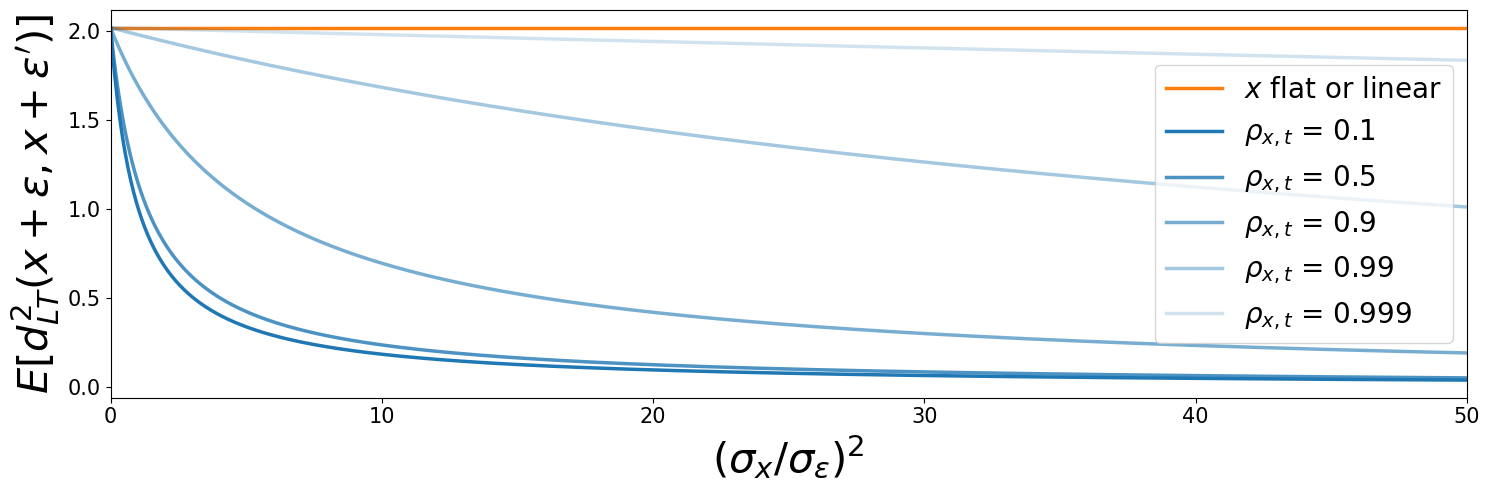

In [1314]:
wlen = 100 
ratio_var = np.linspace(0,50,1000)
rhos = [0.1,0.5,0.9,0.99,0.999]
plt.figure(figsize = (15,5))
plt.axhline(2* (wlen/(wlen-1)),color = "tab:orange", label=r"$x$ flat or linear",linewidth = 2.5)
for i,rho in enumerate(rhos):
    mean_dist = 2* (wlen/(wlen-1))*1/(1+ratio_var*(1-rho**2))
    plt.plot(ratio_var,mean_dist, label = r"$\rho_{x,t}$"+f" = {rho}",color = "tab:blue",alpha = 1-i/(len(rhos)),linewidth=2.5)
plt.xlim((0,50))
plt.xlabel(r"$(\sigma_x/\sigma_\epsilon)^2$",fontsize = 30)
plt.ylabel(r"$E[d^2_{LT}(x+\epsilon,x+\epsilon')]$",fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks([0,0.5,1,1.5,2],fontsize=15)
plt.legend(fontsize=20)
plt.tight_layout()


# Real Data

## ECG

In [1330]:
import wfdb

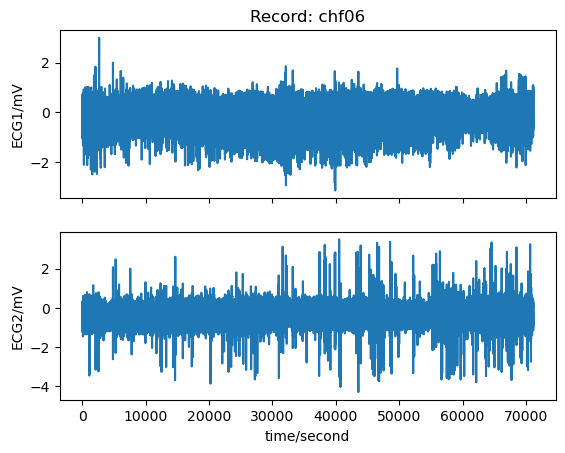

In [1331]:
idx = 6
record = wfdb.rdrecord(f'/Volumes/Ultra Touch/Data/physionet/chfdb/chf0{idx}')
wfdb.plot_wfdb(record=record)

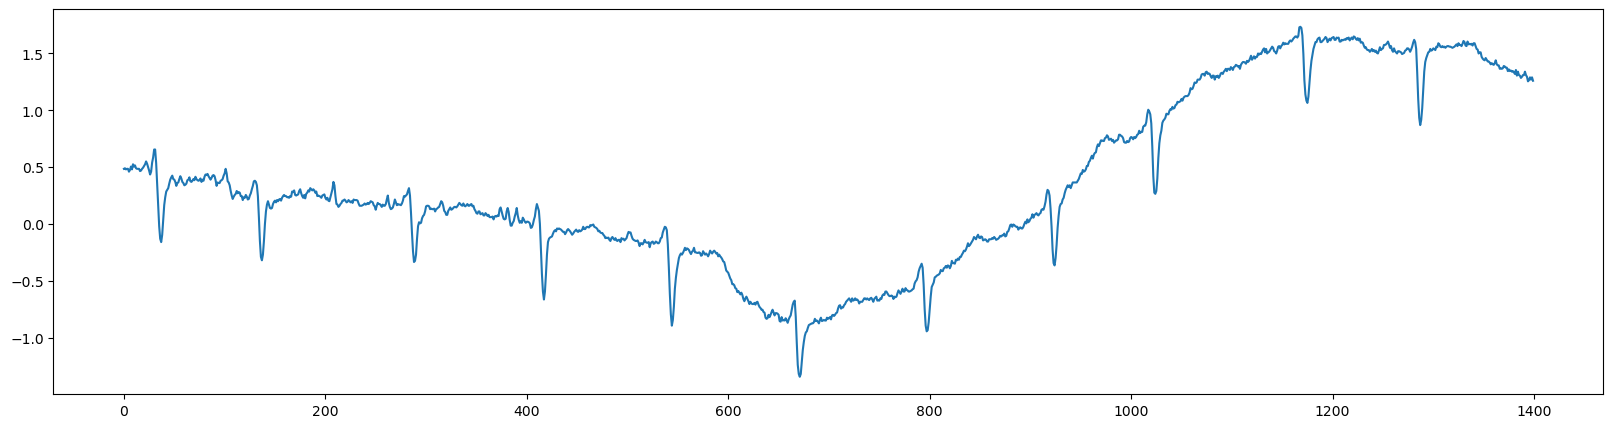

In [1279]:
signal = record.p_signal[:,1]
signal = signal[-91000:-89600]
plt.figure(figsize=(20,5))
plt.plot(signal)

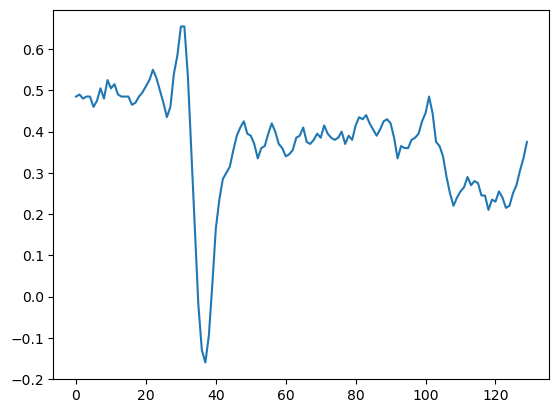

In [1280]:
subsequence = signal[:130].copy()
plt.plot(subsequence)

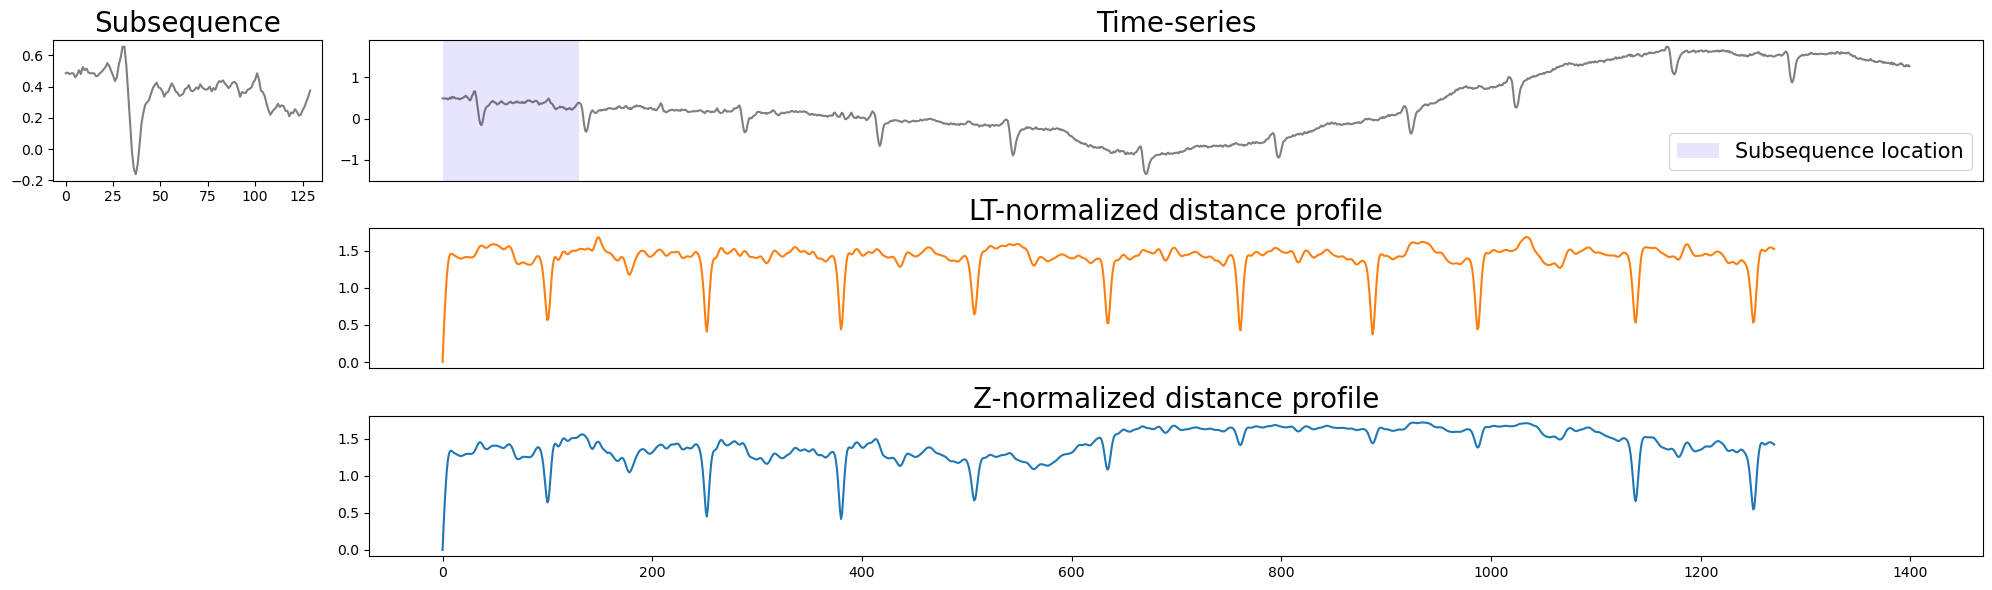

In [1283]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(0,len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend(fontsize=15)

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence",fontsize =20)
axs[0,1].set_title("Time-series",fontsize =20)
axs[1,1].set_title("LT-normalized distance profile",fontsize =20)
axs[2,1].set_title("Z-normalized distance profile",fontsize =20)

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

## Taxi

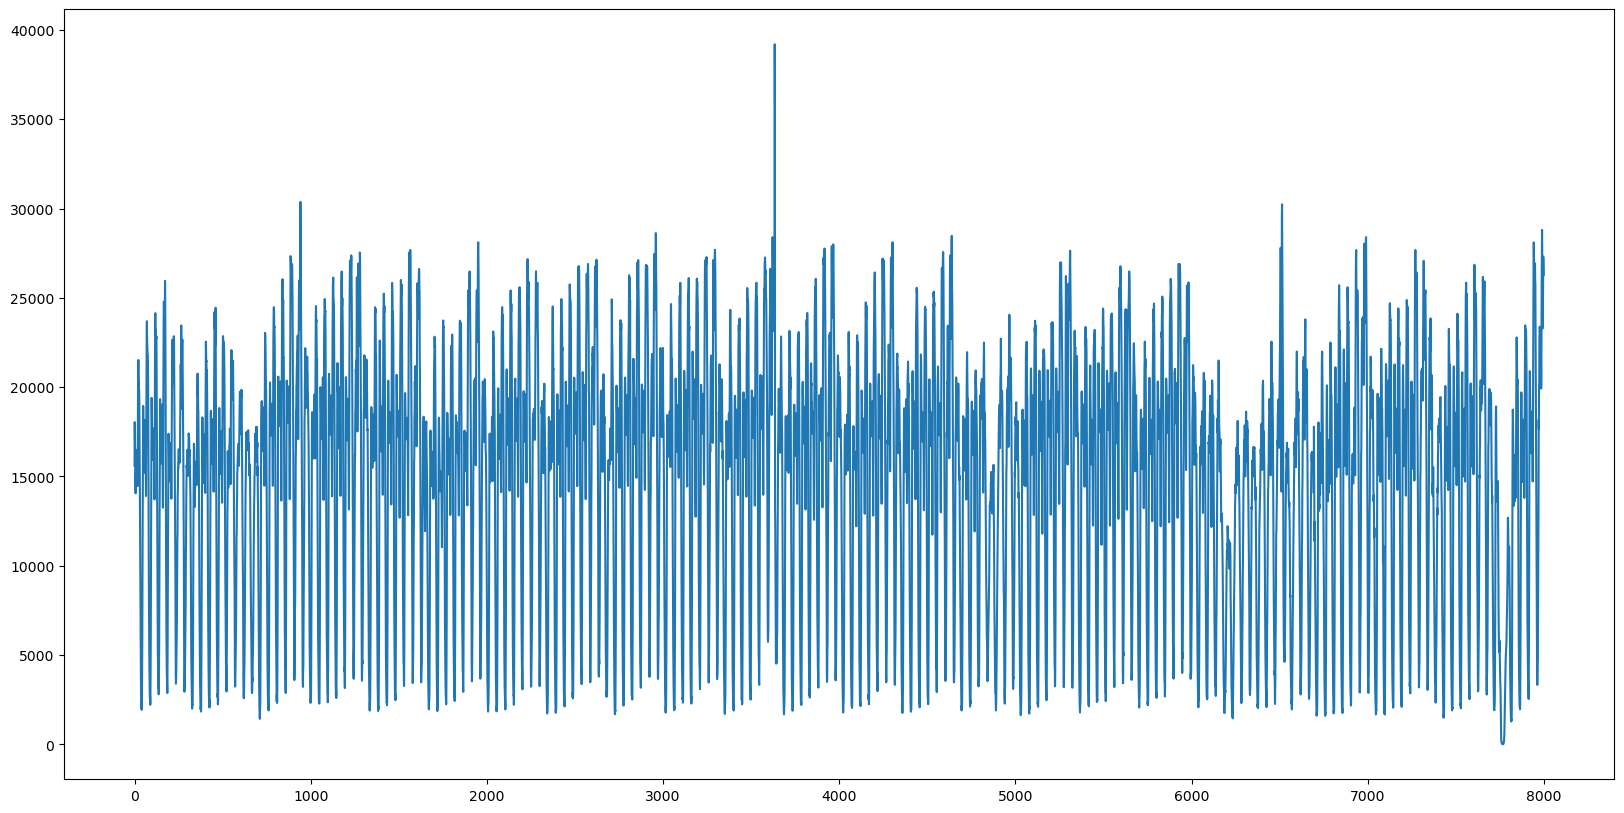

In [589]:
from loadmydata.load_nyc_taxi import load_nyc_taxi_dataset

X, y, description = load_nyc_taxi_dataset()
signal = X["taxi_count"].values
plt.figure(figsize=(20,10))
plt.plot(signal[-8000:])

In [590]:
subsequence = signal[9:57]


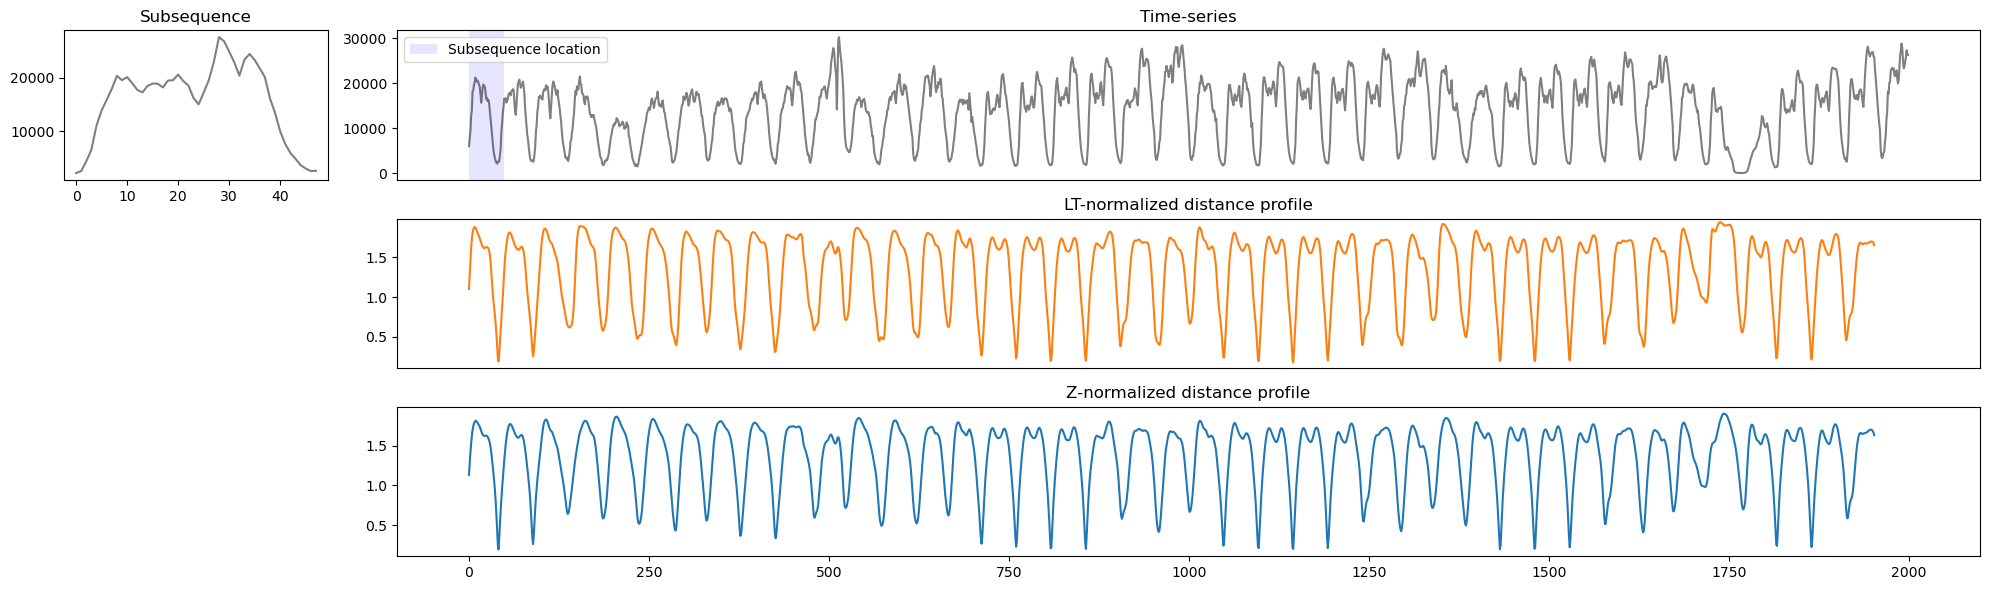

In [591]:
profile_a = a_distanceprofile(signal[-2000:],subsequence)
profile_z = z_distanceprofile(signal[-2000:],subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal[-2000:],color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(0,len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

# Flight

In [200]:
import statsmodels,api as sm
import pandas as pd

In [592]:
airpass = sm.datasets.get_rdataset("AirPassengers", "datasets")

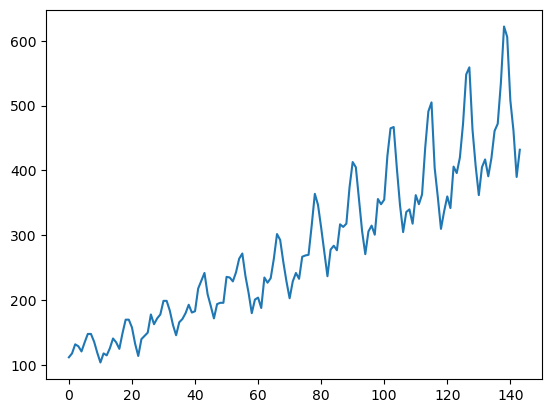

In [593]:
signal = airpass.data["value"].values
plt.plot(signal)

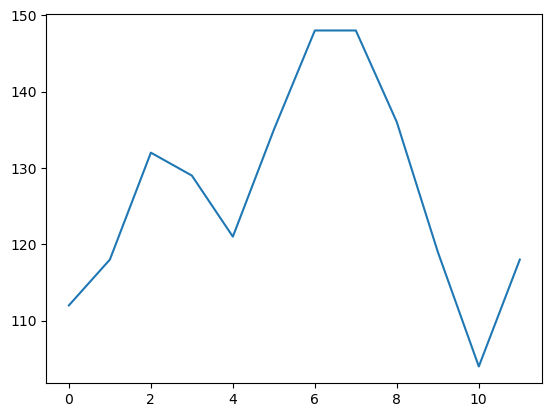

In [594]:
subsequence = signal[:12]
plt.plot(subsequence)

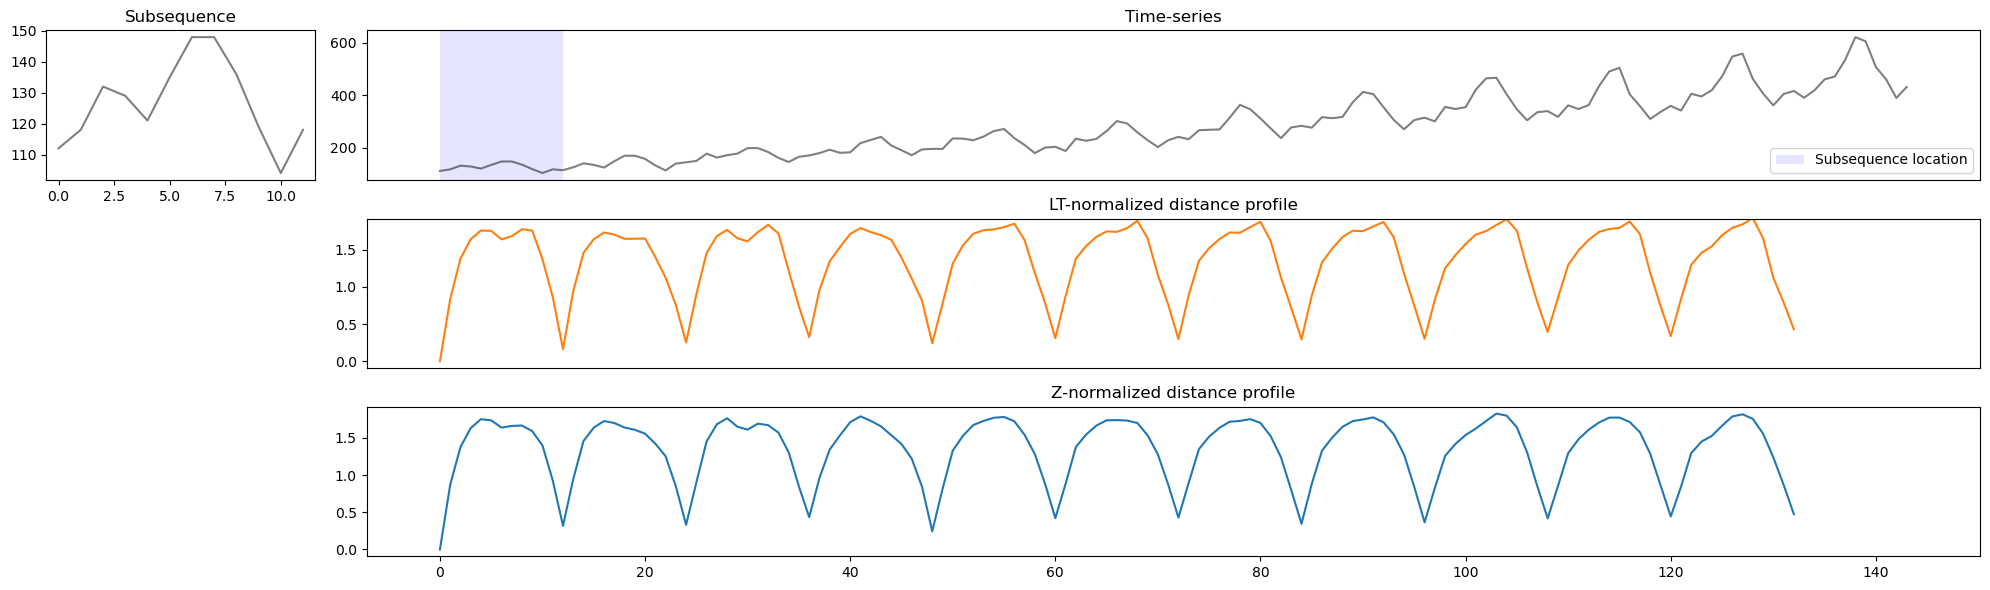

In [595]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(0,len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

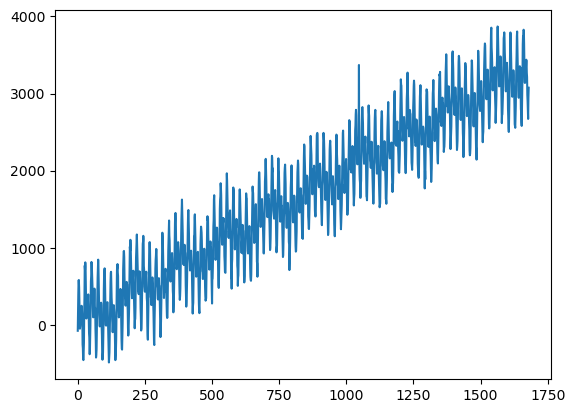

In [564]:
signal = pd.read_csv("/Users/tgermain/Downloads/TSB-UAD-Public/YAHOO/YahooA3Benchmark-TS56_data.out",header=None)[0].values
subsequence = signal[:20]
plt.plot(signal)

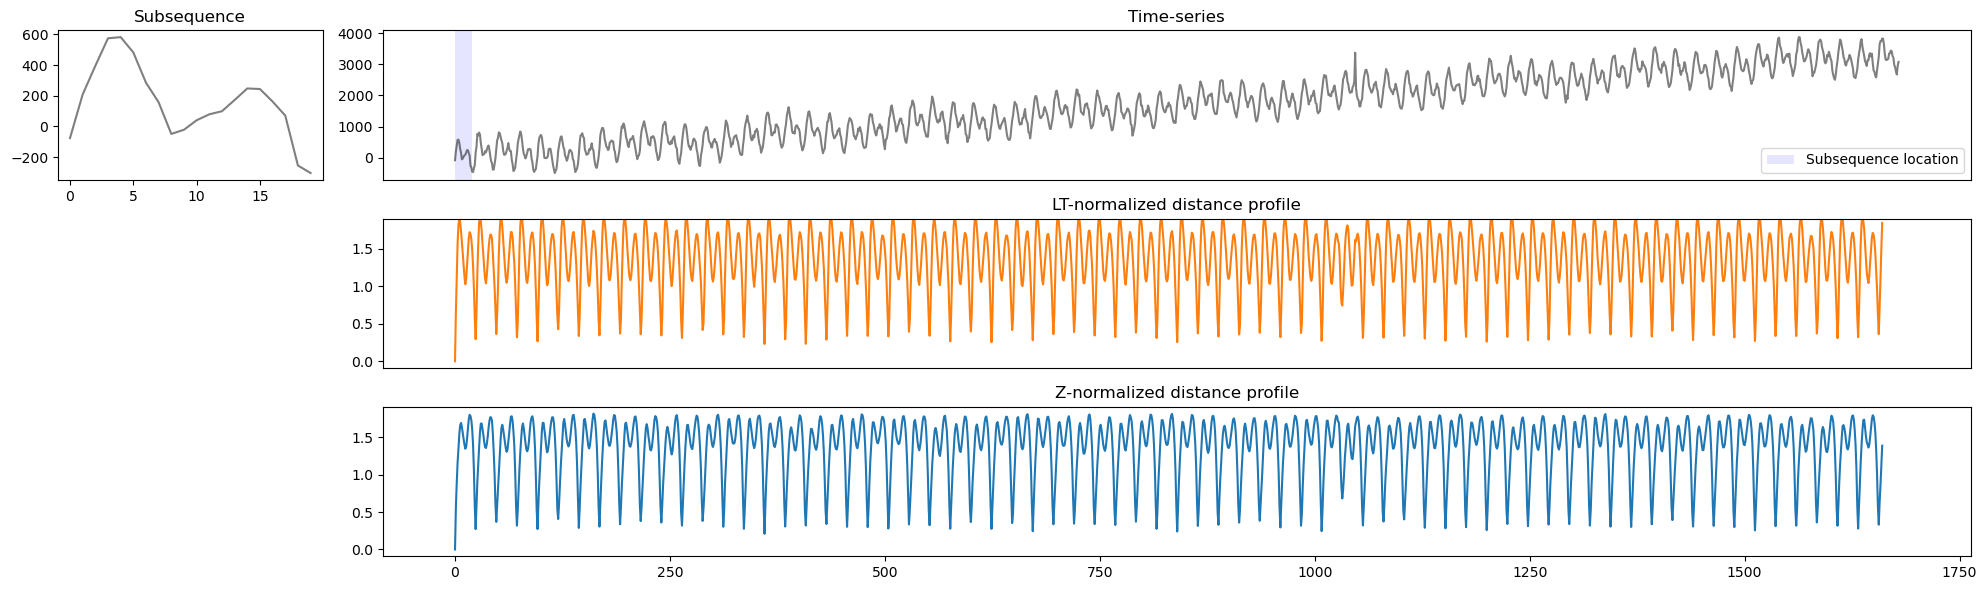

In [565]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(0,len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

## Hearthquake

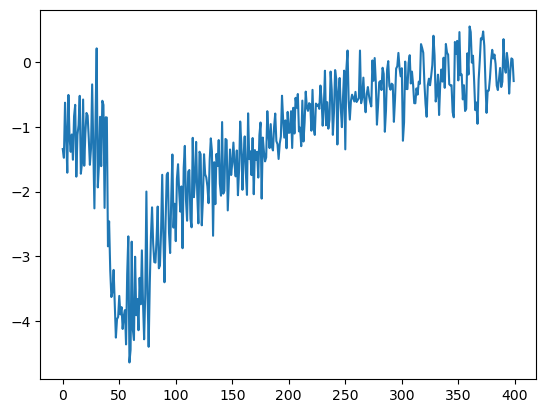

In [586]:
signal = np.loadtxt("/Users/tgermain/Documents/code/tsgraph2/HQ.txt")
subsequence = signal[1500:1900]
plt.plot(signal[1500:1900])

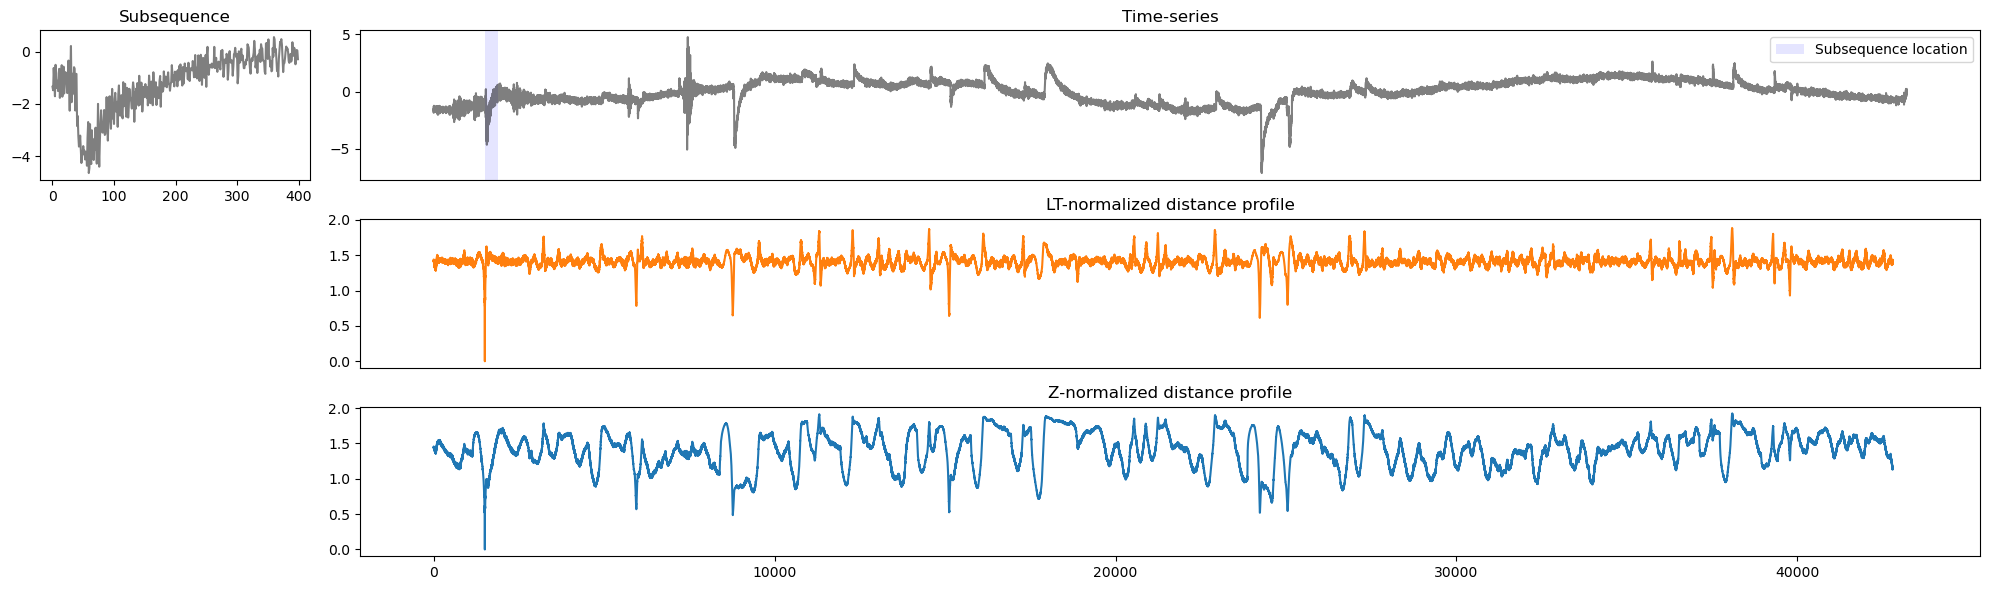

In [588]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(1500,1500+len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

## Last One

In [841]:
df = pd.read_excel("/Users/tgermain/Downloads/time_series.xlsx")

In [842]:
signal = df["AT.2"][6:].values.astype(float)
signal = np.nan_to_num(signal)
signal = signal[4000:6000]

In [843]:
subsequence = signal[:100]

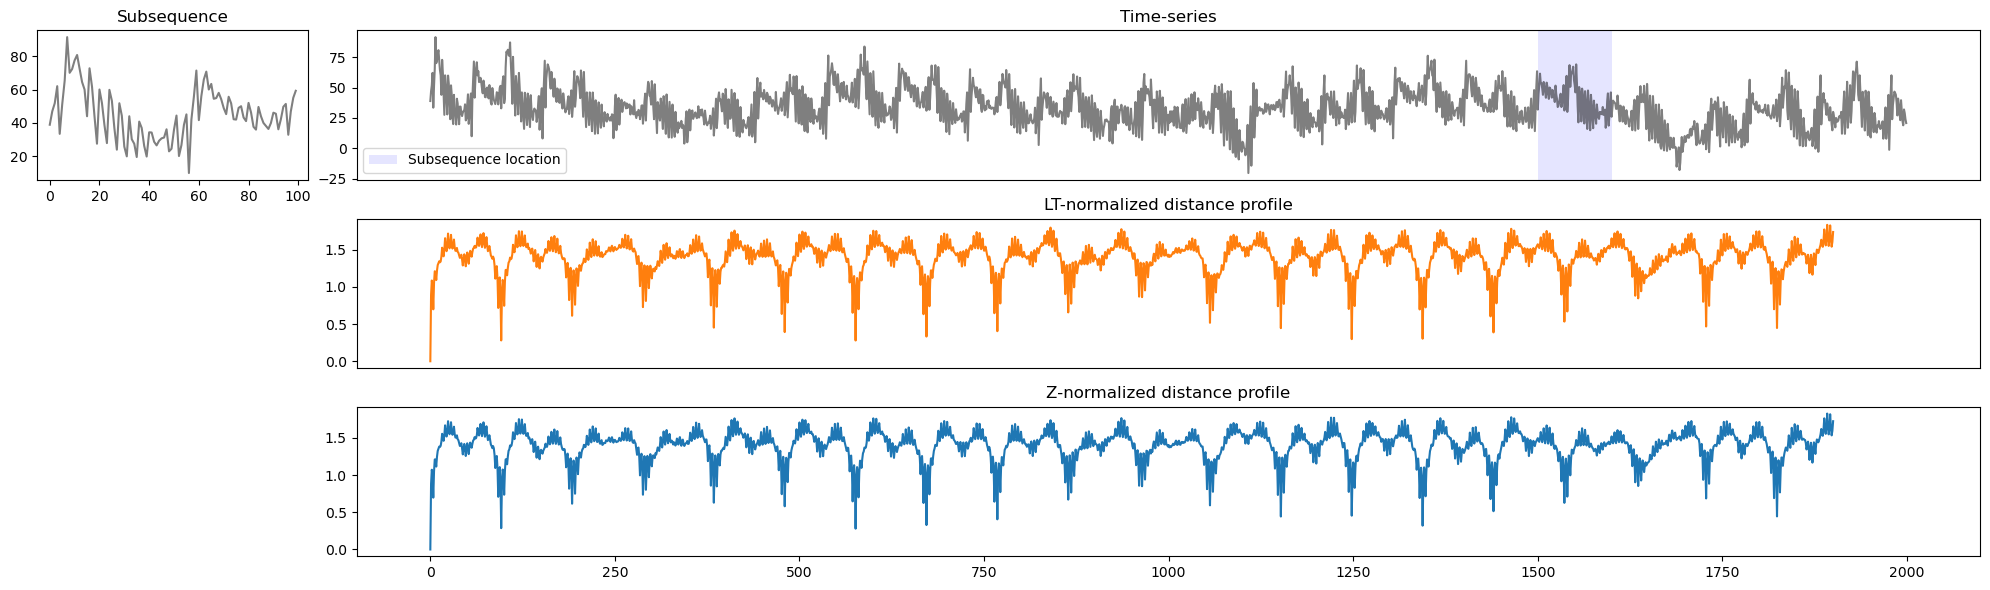

In [844]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(1500,1500+len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

In [845]:
signal = df["DE"][6:].values.astype(float)
signal = np.nan_to_num(signal)
signal = signal[-30000:-24000]
subsequence = signal[170:270]

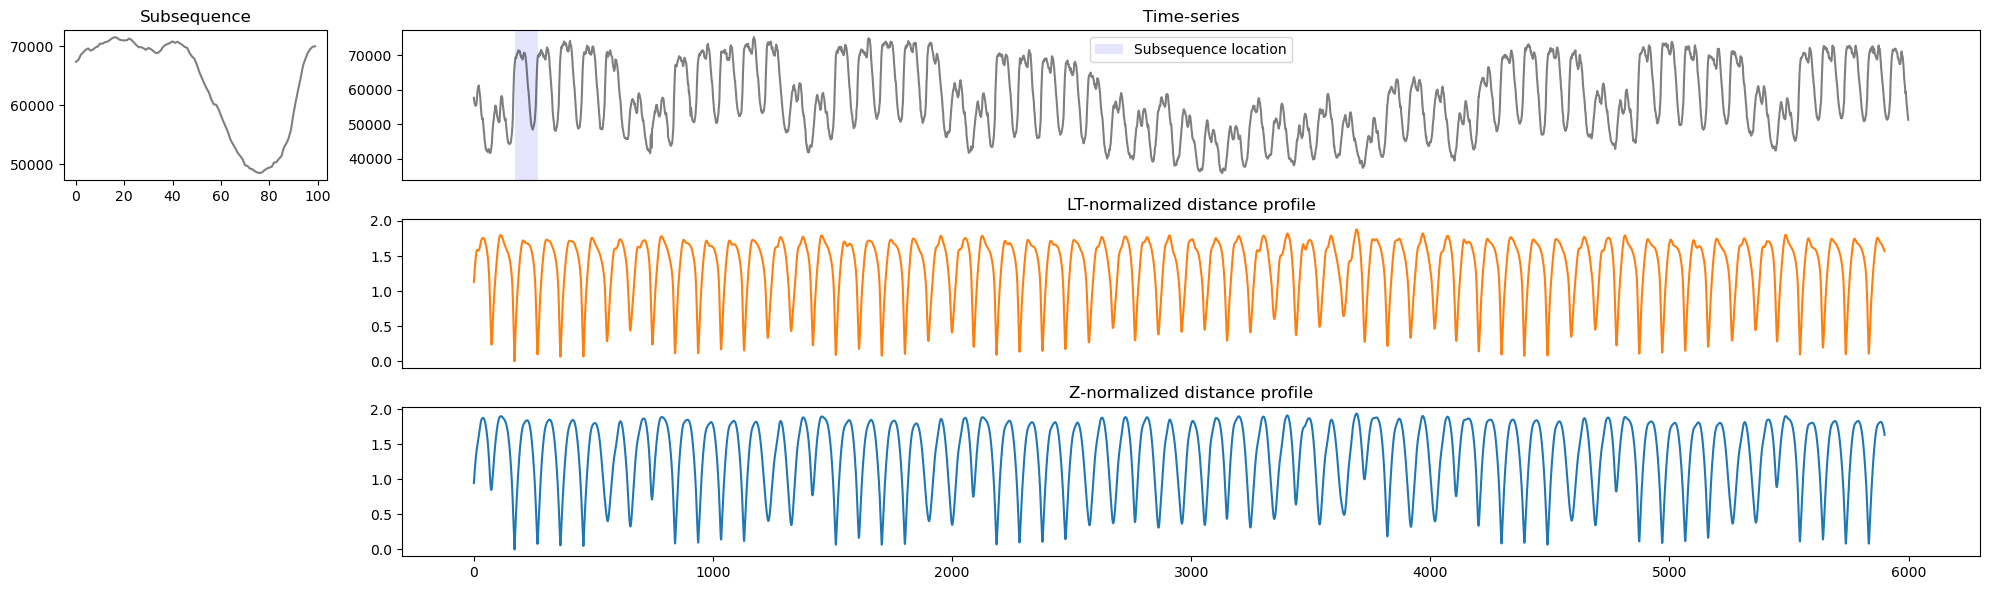

In [846]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(170,170+len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

In [847]:
df.head()

Unnamed: 0 Unnamed: 1                                                 AT  \
0        NaN        NaN                                               load   
1        NaN        NaN                         actual_entsoe_transparency   
2        NaN        NaN                               ENTSO-E Transparency   
3        NaN        NaN  https://transparency.entsoe.eu/load-domain/r2/...   
4        NaN        NaN                                                 MW   

                                                AT.1  \
0                                               load   
1                       forecast_entsoe_transparency   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/load-domain/r2/...   
4                                                 MW   

                                                AT.2  \
0                                              price   
1                                          day_ahead   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/transmission-do...   
4                                                EUR   

                                                AT.3  \
0                                              solar   
1                                  generation_actual   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/generation/r2/a...   
4                                                 MW   

                                                AT.4  \
0                                       wind_onshore   
1                                  generation_actual   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/generation/r2/a...   
4                                                 MW   

                                                  BE  \
0                                               load   
1                         actual_entsoe_transparency   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/load-domain/r2/...   
4                                                 MW   

                                                BE.1  \
0                                               load   
1                       forecast_entsoe_transparency   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/load-domain/r2/...   
4                                                 MW   

                                                  DE  ...  \
0                                               load  ...   
1                         actual_entsoe_transparency  ...   
2                               ENTSO-E Transparency  ...   
3  https://transparency.entsoe.eu/load-domain/r2/...  ...   
4                                                 MW  ...   

                                                HU.2  \
0                                              solar   
1                                  generation_actual   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/generation/r2/a...   
4                                                 MW   

                                                HU.3  \
0                                       wind_onshore   
1                                  generation_actual   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/generation/r2/a...   
4                                                 MW   

                                                  LU  \
0                                               load   
1                         actual_entsoe_transparency   
2                               ENTSO-E Transparency   
3  https://transparency.entsoe.eu/load-domain/r2/...   
4                                                 MW   

                                                LU.1  \
0                                               load   
1                    

In [854]:
tdf

value
time                     
2014-12-31 23:00:00   NaN
2014-12-31 23:15:00   NaN
2014-12-31 23:30:00   NaN
2014-12-31 23:45:00   NaN
2015-01-01 00:00:00   NaN
...                   ...
2020-09-30 22:45:00   NaN
2020-09-30 23:00:00   NaN
2020-09-30 23:15:00   NaN
2020-09-30 23:30:00   NaN
2020-09-30 23:45:00   NaN

[201604 rows x 1 columns]

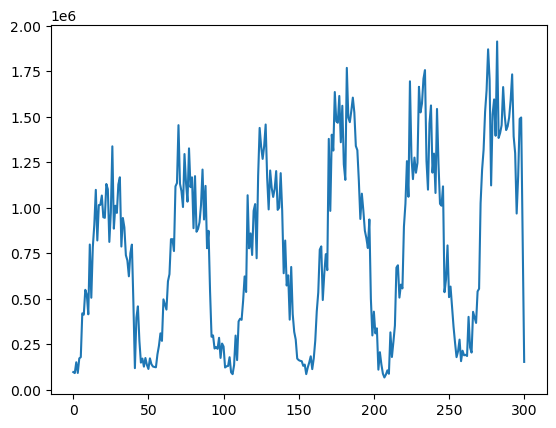

In [862]:
tdf = pd.DataFrame()
tdf["time"]= df.iloc[6:,0]
tdf["value"] = df["DE_50hertz.2"][6:]
tdf = tdf.set_index('time')
plt.plot(tdf.resample("7D").sum().values.reshape(-1)[:500])

In [770]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'AT', 'AT.1', 'AT.2', 'AT.3', 'AT.4', 'BE',
       'BE.1', 'DE', 'DE.1', 'DE.2', 'DE.3', 'DE.4', 'DE.5', 'DE.6', 'DE.7',
       'DE.8', 'DE.9', 'DE.10', 'DE.11', 'DE.12', 'DE.13', 'DE_50hertz',
       'DE_50hertz.1', 'DE_50hertz.2', 'DE_50hertz.3', 'DE_50hertz.4',
       'DE_50hertz.5', 'DE_LU', 'DE_LU.1', 'DE_LU.2', 'DE_LU.3', 'DE_LU.4',
       'DE_LU.5', 'DE_amprion', 'DE_amprion.1', 'DE_amprion.2', 'DE_amprion.3',
       'DE_tennet', 'DE_tennet.1', 'DE_tennet.2', 'DE_tennet.3', 'DE_tennet.4',
       'DE_tennet.5', 'DE_transnetbw', 'DE_transnetbw.1', 'DE_transnetbw.2',
       'DE_transnetbw.3', 'HU', 'HU.1', 'HU.2', 'HU.3', 'LU', 'LU.1', 'NL',
       'NL.1', 'NL.2', 'NL.3', 'NL.4', 'NL.5'],
      dtype='object')

In [851]:
df["DE_50hertz.2"]

0                                                     solar
1                                         generation_actual
2                                      ENTSO-E Transparency
3         https://transparency.entsoe.eu/generation/r2/a...
4                                                        MW
                                ...                        
201605                                                  NaN
201606                                                  NaN
201607                                                  NaN
201608                                                  NaN
201609                                                  NaN
Name: DE_50hertz.2, Length: 201610, dtype: object

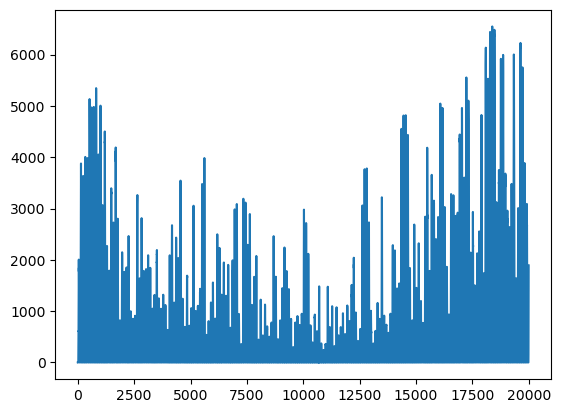

In [852]:
signal = df["DE_50hertz.2"][6:].values.astype(float)
plt.plot(signal[60000:80000])

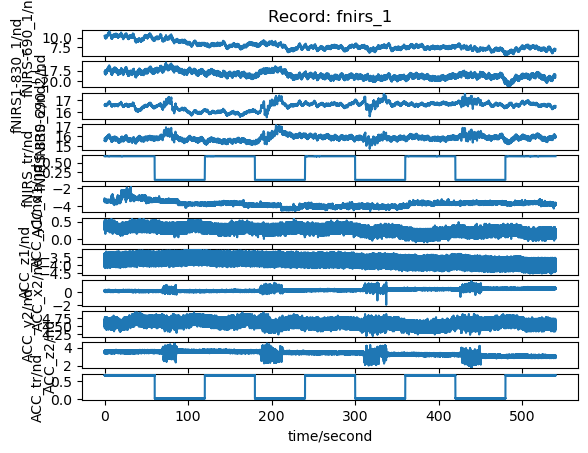

In [863]:
record = wfdb.rdrecord("/Volumes/Ultra Touch/Data/physionet/motion-artifact/fnirs_1")
wfdb.plot_wfdb(record=record)

In [864]:
df = record.to_dataframe()
df.columns


Index(['fNIRS-690_1', 'fNIRS1-830_1', 'fNIRS-690_2', 'fNIRS-830_2', 'fNIRS_tr',
       'ACC_x1', 'ACC_y1', 'ACC_z1', 'ACC_x2', 'ACC_y2', 'ACC_z2', 'ACC_tr'],
      dtype='object')

In [908]:
signal = df["fNIRS-830_2"].values.reshape(-1)
signal = signal[12000:18000]
subsequence = signal[30:230]

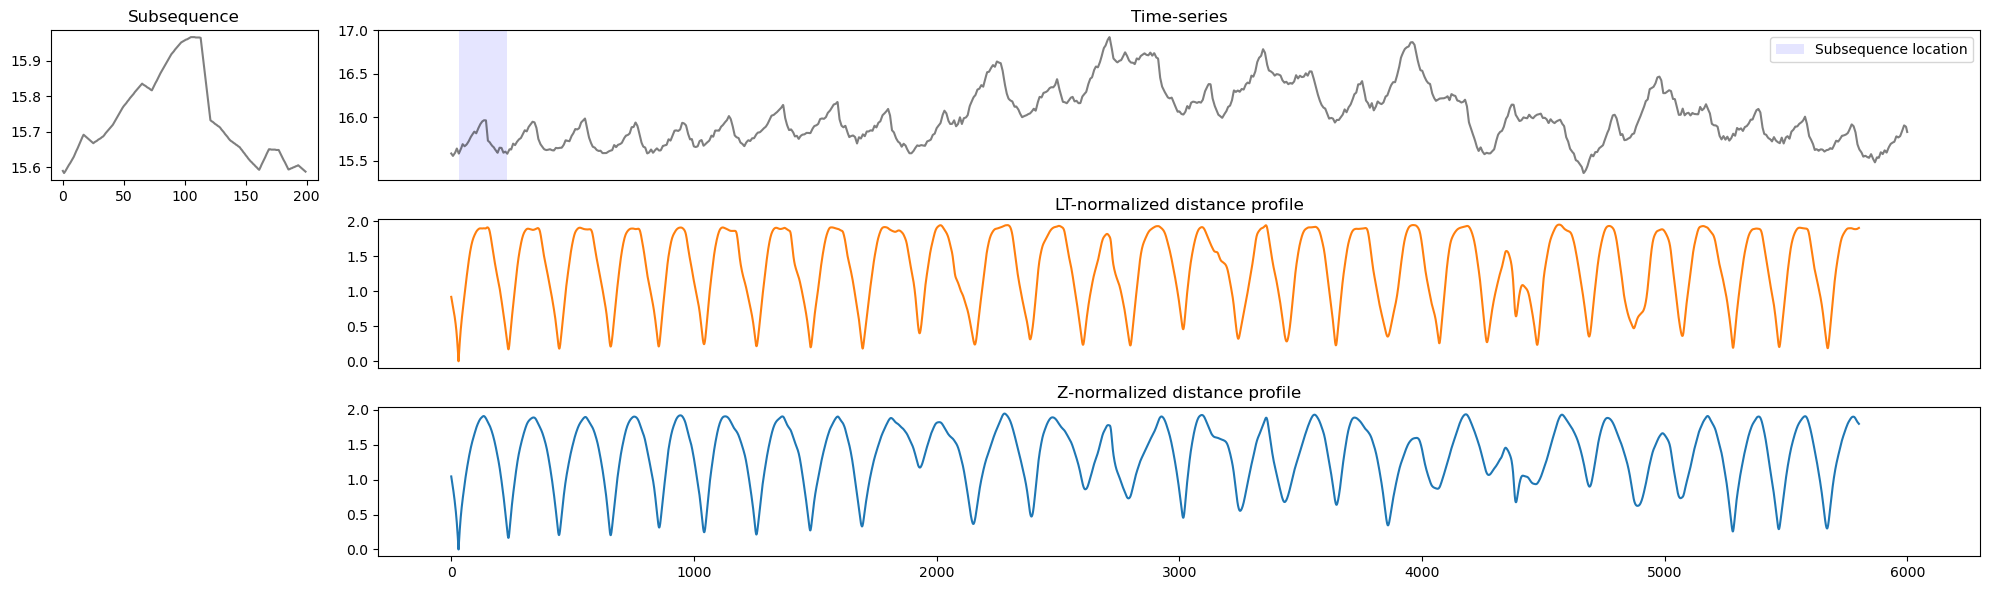

In [909]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(30,30+len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

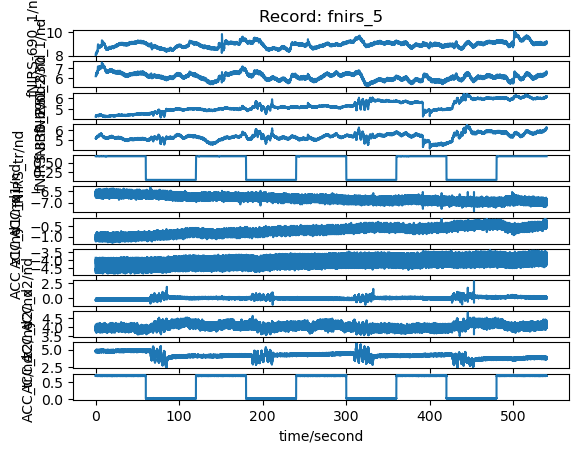

In [1143]:
record = wfdb.rdrecord("/Volumes/Ultra Touch/Data/physionet/motion-artifact/fnirs_5")
wfdb.plot_wfdb(record=record)

In [1144]:
df = record.to_dataframe()
df.columns


Index(['fNIRS-690_1', 'fNIRS1-830_1', 'fNIRS-690_2', 'fNIRS-830_2', 'fNIRS_tr',
       'ACC_x1', 'ACC_y1', 'ACC_z1', 'ACC_x2', 'ACC_y2', 'ACC_z2', 'ACC_tr'],
      dtype='object')

In [1171]:
signal = df["fNIRS-830_2"].values.reshape(-1)
signal = signal[85000:90000]
subsequence = signal[110:240]

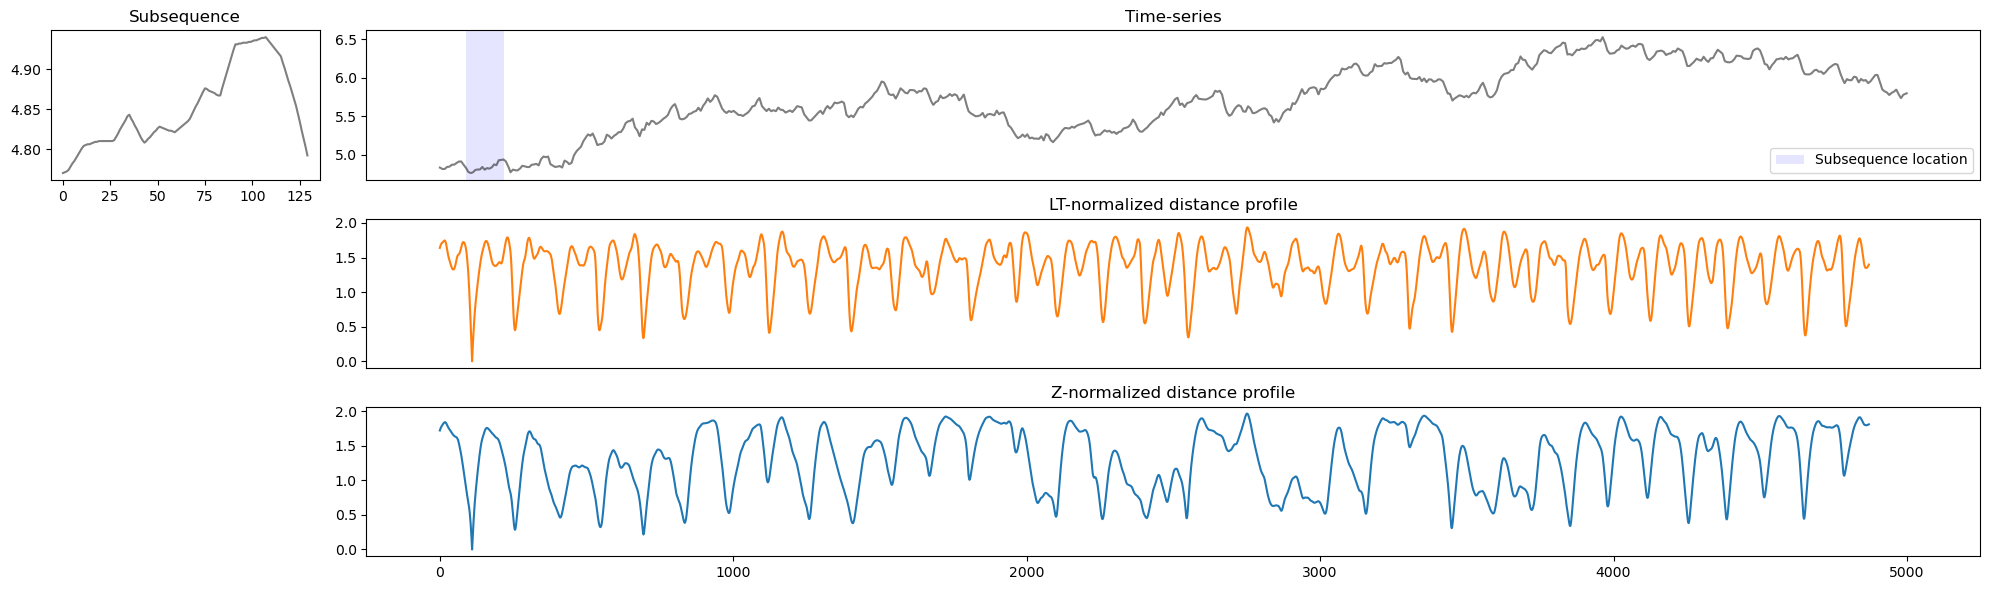

In [1172]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(90,90+len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

In [950]:
signal = df["fNIRS-830_2"].values.reshape(-1)
signal = signal[85000:92000]
subsequence = signal[60:240]

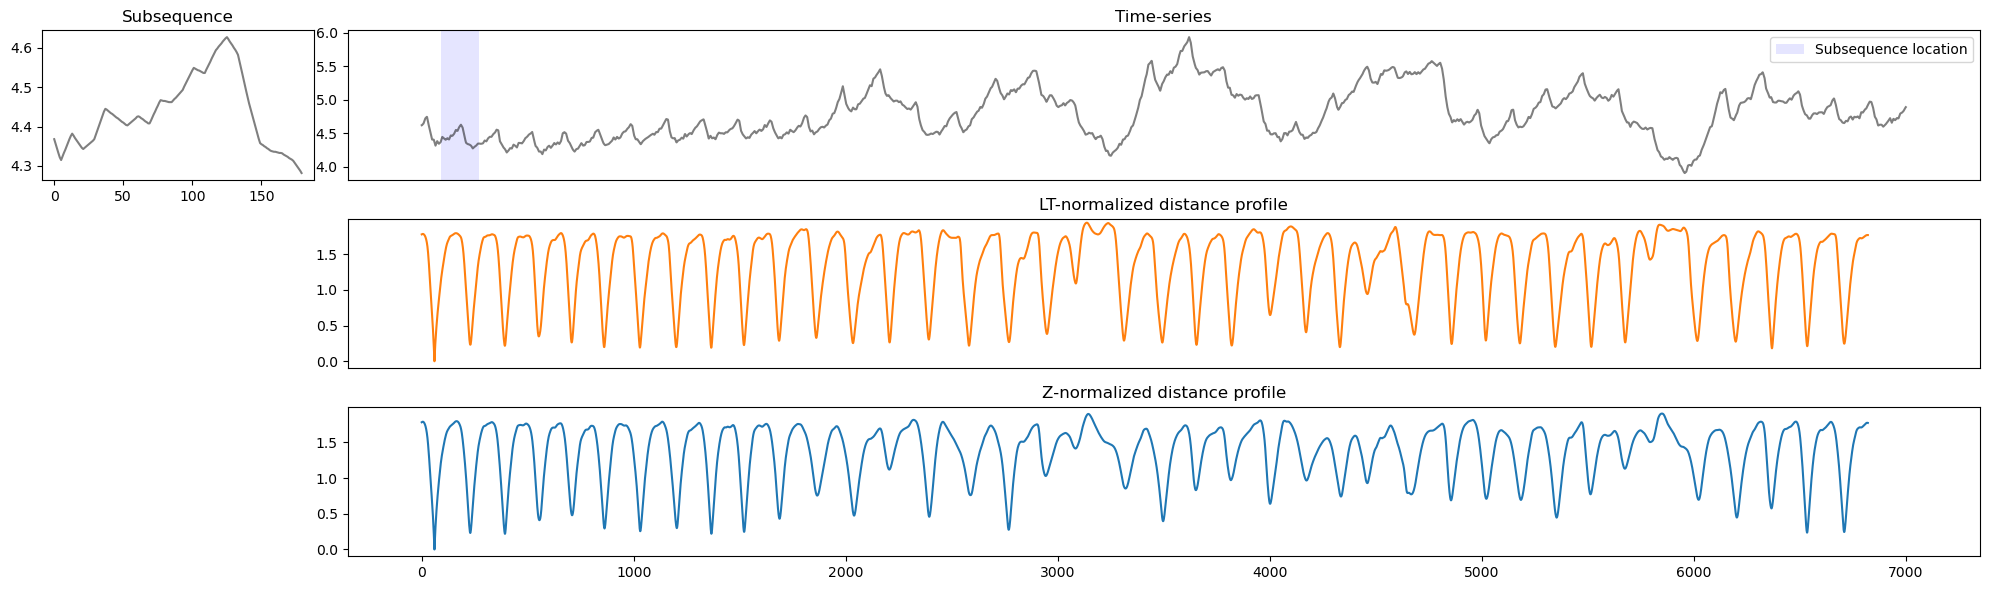

In [951]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(90,90+len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

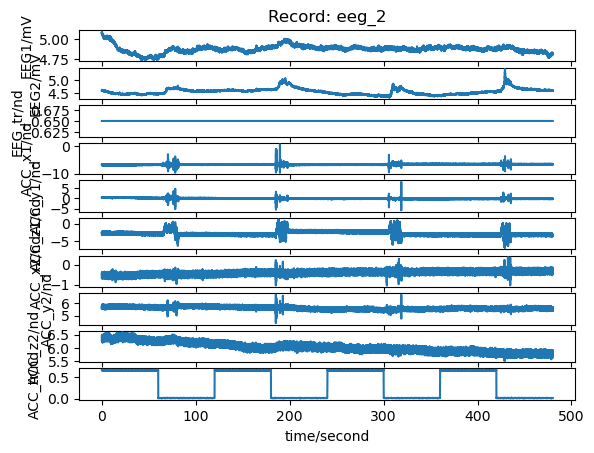

In [952]:
record = wfdb.rdrecord("/Volumes/Ultra Touch/Data/physionet/motion-artifact/eeg_2")
wfdb.plot_wfdb(record=record)

In [953]:
df = record.to_dataframe()
df.columns

Index(['EEG1', 'EEG2', 'EEG_tr', 'ACC_x1', 'ACC_y1', 'ACC_z1', 'ACC_x2',
       'ACC_y2', 'ACC_z2', 'ACC_tr'],
      dtype='object')

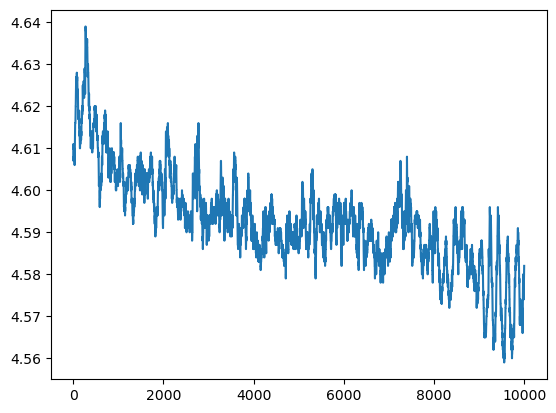

In [957]:
signal = df["EEG2"].values.reshape(-1)
plt.plot(signal[:10000])

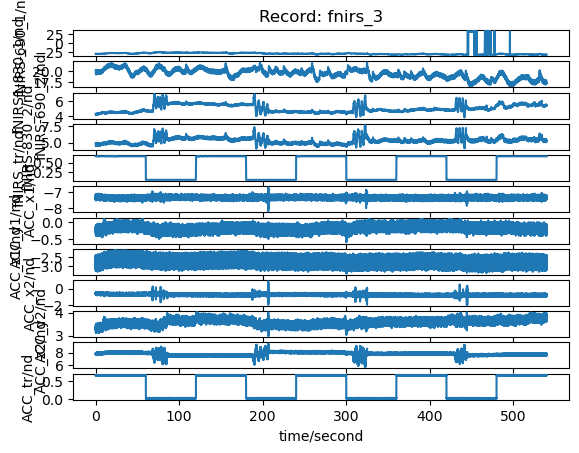

In [958]:
record = wfdb.rdrecord("/Volumes/Ultra Touch/Data/physionet/motion-artifact/fnirs_3")
wfdb.plot_wfdb(record=record)

In [959]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd


# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


# Example of usage
# loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

# print(loaded_data)
# print(frequency)
# print(forecast_horizon)
# print(contain_missing_values)
# print(contain_equal_length)

In [1111]:
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length  = convert_tsf_to_dataframe("/Users/tgermain/Downloads/us_births_dataset.tsf")

In [1112]:
loaded_data

series_name start_timestamp  \
0          T1      1969-01-01   

                                        series_value  
0  [8486.0, 9002.0, 9542.0, 8960.0, 8390.0, 9560....

In [1113]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [1125]:
signal = np.array(loaded_data["series_value"].iloc[0])
signal = moving_average(signal,7)
subsequence = signal[850:1150]


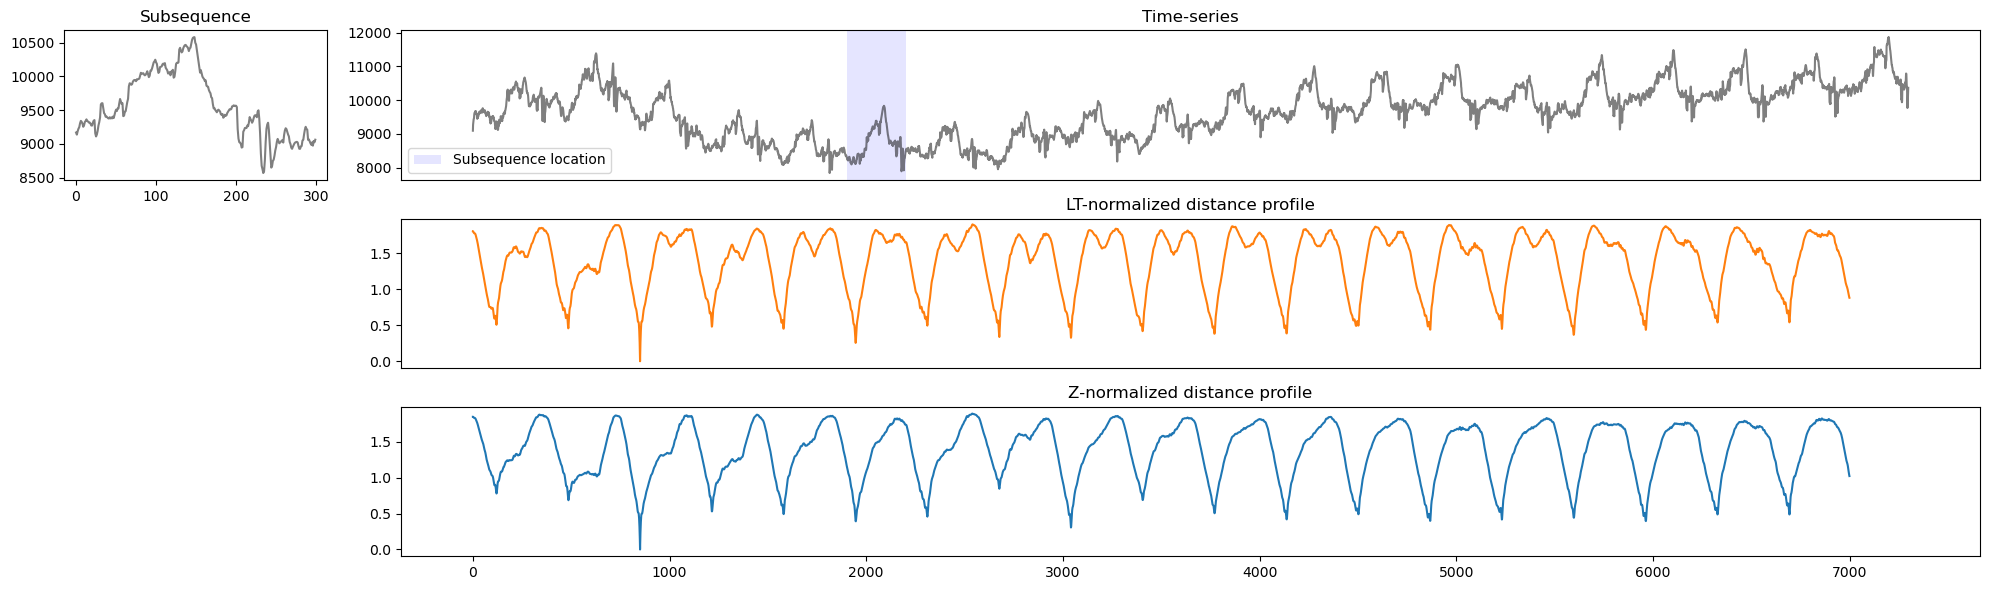

In [1126]:
profile_a = a_distanceprofile(signal,subsequence)
profile_z = z_distanceprofile(signal,subsequence)
fig,axs = plt.subplots(3,2,figsize = (20,6),gridspec_kw={'width_ratios': [1, 6]})
axs[0,0].plot(subsequence,color = "black", alpha = 0.5)
axs[0,1].plot(signal,color = "black", alpha = 0.5)
#rct = Rectangle((-1,min(subsequence)),len(subsequence)*1.,(max(subsequence)-min(subsequence))*1.1,alpha=1,fill = None)
#axs[0,1].add_patch(rct)
axs[0,1].axvspan(1900,1900+len(subsequence),facecolor = "blue", alpha=0.1,label = "Subsequence location")
axs[0,1].legend()

axs[1,1].plot(profile_a,color = "tab:orange",alpha=1)
axs[2,1].plot(profile_z,color = "tab:blue",alpha=1)

axs[2,1].sharex(axs[0,1])
axs[0,1].sharex(axs[1,1])
axs[1,1].sharey(axs[2,1])

axs[1,1].set_xticks([])

axs[0,0].set_title("Subsequence")
axs[0,1].set_title("Time-series")
axs[1,1].set_title("LT-normalized distance profile")
axs[2,1].set_title("Z-normalized distance profile")

fig.delaxes(axs[1,0])
fig.delaxes(axs[2,0])
fig.tight_layout()

In [1107]:
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length  = convert_tsf_to_dataframe("/Users/tgermain/Downloads/london_smart_meters_dataset_without_missing_values.tsf")

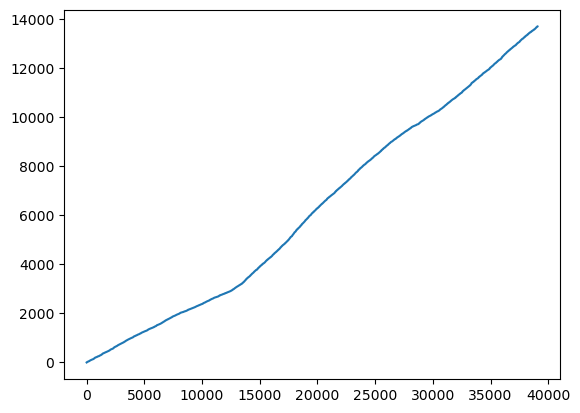

In [1110]:
signal = np.array(loaded_data["series_value"].iloc[1])
#signal = moving_average(signal,24)
#signal = np.sum(signal[:int(len(signal)/900)*900].reshape(-1,900),axis=1)
plt.plot(np.cumsum(signal))

In [1093]:
3600/4

900.0